In [112]:
# imports
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import numpy as np
from sklearn import ensemble, feature_extraction, metrics, model_selection, pipeline, preprocessing
from collections import Counter
from boruta import BorutaPy
from IPython import display
from pyteomics import electrochem, mass, parser
%matplotlib inline
pd.options.display.max_rows = 10
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 6

## Variables

In [116]:
# positive (peptide) classes
peptides = ['EIYKRWII', 'FLKEKGGL']

# negative (control) class
negative = 'Control'

# all classes
classes = peptides + [negative]

# V and J gene as list
genes = ['V_gene', 'J_gene']

# amino acids
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',]

# physicochemical amino acid properties
basicity = {'A': 206.4, 'B': 210.7, 'C': 206.2, 'D': 208.6, 'E': 215.6, 'F': 212.1, 'G': 202.7,
            'H': 223.7, 'I': 210.8, 'K': 221.8, 'L': 209.6, 'M': 213.3, 'N': 212.8, 'P': 214.4,
            'Q': 214.2, 'R': 237.0, 'S': 207.6, 'T': 211.7, 'V': 208.7, 'W': 216.1, 'X': 210.2,
            'Y': 213.1, 'Z': 214.9}

hydrophobicity = {'A': 0.16, 'B': -3.14, 'C': 2.50, 'D': -2.49, 'E': -1.50, 'F': 5.00, 'G': -3.31,
                  'H': -4.63, 'I': 4.41, 'K': -5.00, 'L': 4.76, 'M': 3.23, 'N': -3.79, 'P': -4.92,
                  'Q': -2.76, 'R': -2.77, 'S': -2.85, 'T': -1.08, 'V': 3.02, 'W': 4.88, 'X': 4.59,
                  'Y': 2.00, 'Z': -2.13}

helicity = {'A': 1.24, 'B': 0.92, 'C': 0.79, 'D': 0.89, 'E': 0.85, 'F': 1.26, 'G': 1.15, 'H': 0.97,
            'I': 1.29, 'K': 0.88, 'L': 1.28, 'M': 1.22, 'N': 0.94, 'P': 0.57, 'Q': 0.96, 'R': 0.95,
            'S': 1.00, 'T': 1.09, 'V': 1.27, 'W': 1.07, 'X': 1.29, 'Y': 1.11, 'Z': 0.91}

mutation_stability = {'A': 13, 'C': 52, 'D': 11, 'E': 12, 'F': 32, 'G': 27, 'H': 15, 'I': 10,
                      'K': 24, 'L': 34, 'M':  6, 'N':  6, 'P': 20, 'Q': 10, 'R': 17, 'S': 10,
                      'T': 11, 'V': 17, 'W': 55, 'Y': 31}

physchems = {'basicity':basicity, 'hydrophobicity':hydrophobicity,
             'helicity':helicity, 'mutation stability':mutation_stability}

## Reading and parsing input data

**TODO**: write explanation of source of data and preprocessing of it

In [117]:
def split_rows(df, column, symbol):
    
    ''' Given a dataframe, the name of a column in the dataframe and a symbol to split on:
    Split rows in two rows if that row's column value contains the symbol to split on.
    Each new row is identical to the original except for the column value which is replaced by one of its split parts.
    '''
    
    s = df[column].str.split(symbol, expand=True).stack()
    i = s.index.get_level_values(0)
    df2 = df.loc[i].copy()
    df2[column] = s.values
    return df2

def fix_gene_format(gene_string):
    
    ''' Make format in which V- and J-genes are encoded uniform and reduce to family level. '''
    if gene_string == 'unresolved':
        return gene_string
    if '-' in gene_string:
        gene_string = gene_string.split('-')[0]
    if len(gene_string) != 2:
        gene_string = '0'+gene_string
    return gene_string

# read peptide data
peptide_data = pd.read_csv('data.csv')
# J_genes don't contain double genes in the peptide dataset => only split on V_gene
peptide_data = split_rows(peptide_data, 'V_gene', '/') 

# read control data; splits were already done during processing of immuneaccess data
control_data = pd.read_csv('control_data.csv')

# combine control and peptide data
data = pd.concat([peptide_data, control_data], ignore_index=True)
for gene in genes:
    data[gene] = data[gene].apply(lambda x: fix_gene_format(x))

# show data
for target in classes:
    display.display(data[data['HLA_peptide'] == target])

,V_gene,CDR3_sequence,J_gene,HLA_peptide
0,27,CASSPNGDRVFDQPQHF,01,EIYKRWII
1,09,CASSVVGDGRETQYF,02,EIYKRWII
2,09,CASSEGQGTTYEQYF,02,EIYKRWII
3,02,CASSEAATGRGNQPQHF,01,EIYKRWII
4,09,CASSVLHGRQETQYF,02,EIYKRWII
...,...,...,...,...
137,28,CASSLPPPGIKGELFF,02,EIYKRWII
138,07,CASSTLPGTPRNEQYF,02,EIYKRWII
139,09,CASSVGGDARETQYF,02,EIYKRWII
140,02,CASSASTKDTQYF,02,EIYKRWII


,V_gene,CDR3_sequence,J_gene,HLA_peptide
142,02,CASSVLAGLGNEQFF,02,FLKEKGGL
143,02,CASSVLAGHGNGQFF,02,FLKEKGGL
144,11,CASSLLAGLTDTQYF,02,FLKEKGGL
145,02,CASSVLAGLGNEQFF,02,FLKEKGGL
146,02,CASSVLAGLGNEQFF,02,FLKEKGGL
...,...,...,...,...
232,07,CASSLAPGTSGSPYNEQFF,02,FLKEKGGL
233,14,CASSLGTGIANYGYTF,02,FLKEKGGL
234,14,CASSLGTGIANYGYTF,02,FLKEKGGL
235,24,CATKGTGLYNEQFF,02,FLKEKGGL


,V_gene,CDR3_sequence,J_gene,HLA_peptide
237,14,CASSPGESYEQYF,02,Control
238,14,CASSPSYRGEQYF,02,Control
239,14,CASSQWGTYEQYF,02,Control
240,14,CASSQTQFQPQHF,01,Control
241,14,CASSHLGGDEQFF,02,Control
...,...,...,...,...
58141,29,CSASTSGPETGNEQFF,02,Control
58142,29,CSASLVDAPMVNEQFF,02,Control
58143,29,CSAGTGGLGSNQPQHF,01,Control
58144,29,CTIARGTPLSTDTQYF,02,Control


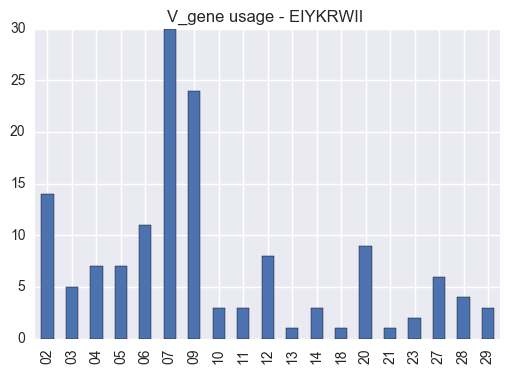

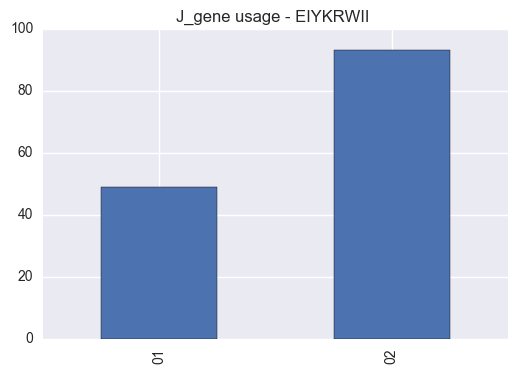

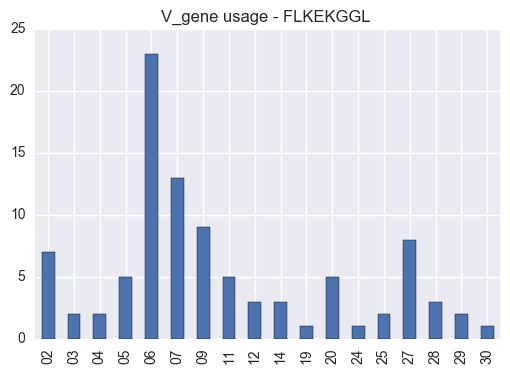

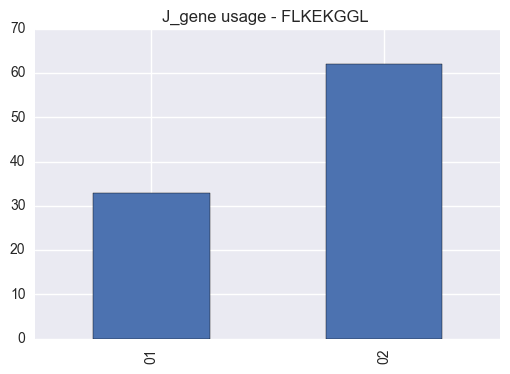

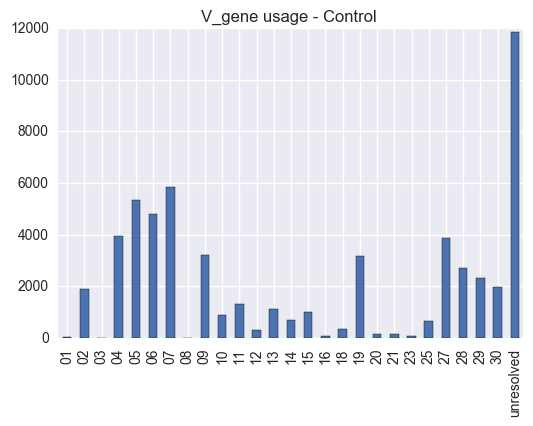

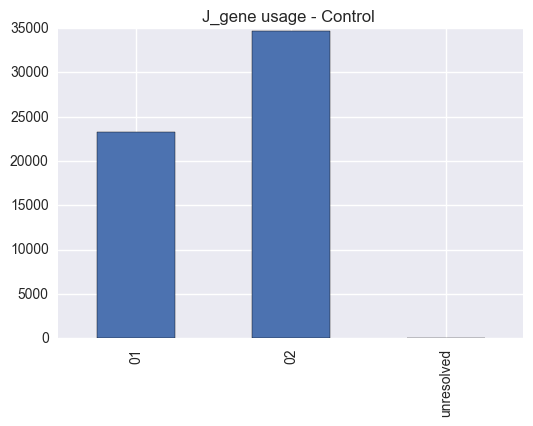

In [118]:
# show V_gene and J_gene usage
for target in classes:
    for gene in genes:
        plt.figure()
        plt.title('{} usage - {} '.format(gene, target))
        data[data['HLA_peptide'] == target][gene].value_counts().sort_index().plot(kind='bar')

## Feature generation

Create features for each sequence based on:
* V-gene usage (one-hot)
* J-gene usage (one-hot)
* Sequence length (numerical)
* Amino acid count (numerical)
* Average amino acid properties (basicity, hydrophobicity, helicity, mutational stability) (numerical)
* Position specific amino acid properties (numerical)
* Position specific amino acid presence (one-hot)

In [119]:
# one-hot encode V- and J-gene
onehot_encoder = feature_extraction.DictVectorizer(sparse=False)
encoded_genes = pd.DataFrame(
        onehot_encoder.fit_transform(data[['V_gene', 'J_gene']].to_dict(orient='records')),
        columns=onehot_encoder.feature_names_)
display.display(encoded_genes)

,J_gene=01,J_gene=02,J_gene=unresolved,V_gene=01,V_gene=02,V_gene=03,V_gene=04,V_gene=05,V_gene=06,V_gene=07,...,V_gene=20,V_gene=21,V_gene=23,V_gene=24,V_gene=25,V_gene=27,V_gene=28,V_gene=29,V_gene=30,V_gene=unresolved
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58141,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
58142,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
58143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
58144,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [120]:
# functions

def calc_average_property(sequence, physchem):
    return np.mean([physchem[x] for x in sequence])

# sequence length
length = pd.Series(data['CDR3_sequence'].apply(lambda x: len(x)), name='length')

# amount of each amino acid present in sequence
aa_counts = []
for aa in amino_acids:
    aa_counts.append(pd.Series(data['CDR3_sequence'].apply(lambda x: x.count(aa)), name='{} count'.format(aa)))
aa_counts = pd.concat(aa_counts, axis=1)

# average physicochemical property value of sequence
average_physchems = []
for physchem_name, physchem in physchems.items():
    average_physchems.append(pd.Series(data['CDR3_sequence'].apply(lambda x: calc_average_property(x, physchem)), 
                                       name='average {}'.format(physchem_name)))
average_physchems = pd.concat(average_physchems, axis=1)



,average helicity,average mutation stability,average basicity,average hydrophobicity
0,0.980588,18.411765,212.429412,-1.462353
1,1.065333,19.800000,210.860000,-0.481333
2,1.040667,19.933333,210.300000,-0.756000
3,1.021176,17.529412,211.864706,-1.679412
4,1.058667,20.066667,212.693333,-0.471333
...,...,...,...,...
58141,1.012500,18.437500,210.062500,-1.196250
58142,1.065000,18.437500,210.268750,0.355625
58143,1.041250,20.687500,209.456250,-1.653750
58144,1.053125,19.437500,211.843750,-0.286875
